<a href="https://colab.research.google.com/github/millandmills/homework/blob/main/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Оригинальный размер: (810, 539)
Размер, с которым работаем: (480, 319)


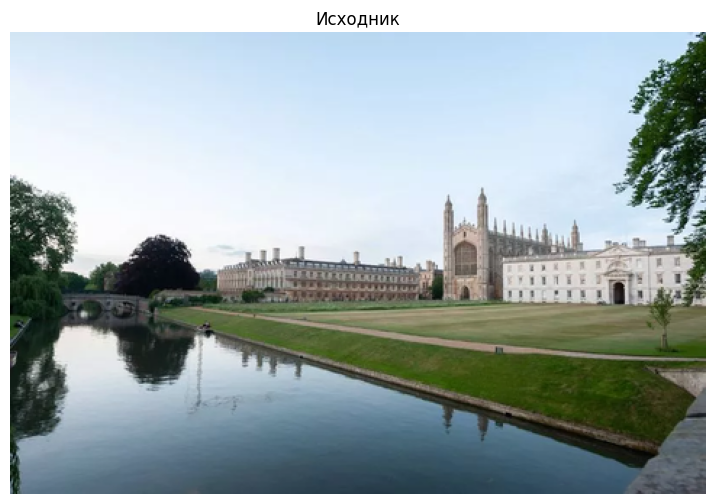

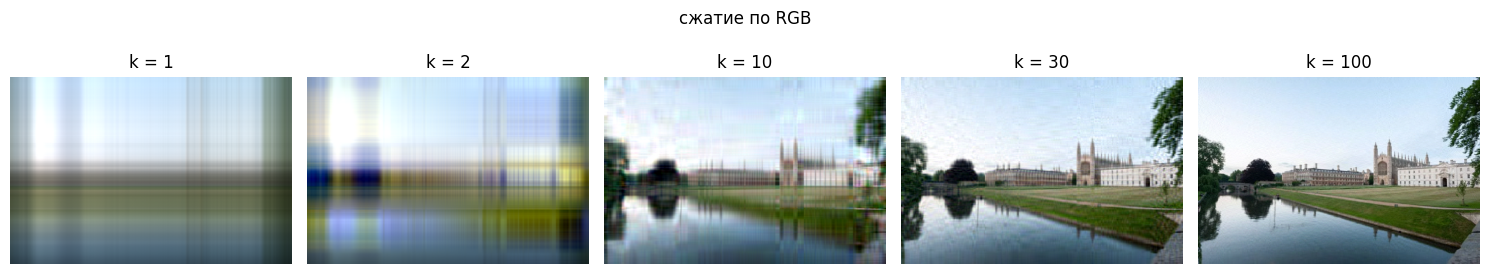

Размер PNG: 171.0 КБ
Размер RGB: 448.6 КБ

Оценка объёма по сингулярным значениям:
k=  1: ~9.4 КБ
k=  2: ~18.8 КБ
k= 10: ~93.8 КБ
k= 30: ~281.2 КБ
k=100: ~937.5 КБ


In [8]:
import io
import os
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)
url = "https://i2-prod.cambridge-news.co.uk/news/cambridge-news/article32642354.ece/ALTERNATES/s810/0_Serene-view-Cambridge-UK.jpg"
resp = requests.get(url, timeout=30)
resp.raise_for_status()

original_img = Image.open(io.BytesIO(resp.content)).convert("RGB")
print("Оригинальный размер:", original_img.size)

max_width = 480
if original_img.width > max_width:
    ratio = max_width / original_img.width
    new_size = (max_width, int(original_img.height * ratio))
    img = original_img.resize(new_size, Image.Resampling.LANCZOS)
else:
    img = original_img.copy()

print("Размер, с которым работаем:", img.size) #мой ноут не потянул бы исходник

plt.imshow(img)
plt.axis("off")
plt.title("Исходник")
plt.show()
def svd_color(pil_img, k):
    arr = np.array(pil_img, dtype=np.float32)
    h, w, _ = arr.shape
    rec = np.zeros_like(arr)
    factors = []
    for c in range(3):  # R, G, B
        channel = arr[:, :, c]
        U, s, Vt = np.linalg.svd(channel, full_matrices=False)
        r = min(k, len(s))  # на случай k > min(h, w)
        U_r, s_r, Vt_r = U[:, :r], s[:r], Vt[:r, :]
        rec[:, :, c] = (U_r @ np.diag(s_r) @ Vt_r)
        factors.append((U_r, s_r, Vt_r))
    rec = np.clip(rec, 0, 255).astype(np.uint8)
    return rec, factors


def compstorage(factors):
    total_numbers = 0
    for U_r, s_r, Vt_r in factors:
        total_numbers += U_r.size + s_r.size + Vt_r.size
    return total_numbers * 4  #float32 = 4 байта
ks = [1, 2, 10, 30, 100]
results = []

for k in ks:
    rec_img, factors = svd_color(img, k)
    results.append((k, rec_img, factors))
    Image.fromarray(rec_img).save(os.path.join(out_dir, f"kings_k{k}.png"))

cols = len(ks)
fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3))
for ax, (k, rec_img, _) in zip(axes, results):
    ax.imshow(rec_img)
    ax.set_title(f"k = {k}")
    ax.axis("off")
plt.suptitle("сжатие по RGB")
plt.tight_layout()
plt.show()
raw_bytes = np.array(img, dtype=np.uint8).size  #сколько байт занимают пиксели без сжатия
file_bytes = os.path.getsize(img_path)  #размер сохранённого PNG
print(f"Размер PNG: {file_bytes/1024:.1f} КБ")
print(f"Размер RGB: {raw_bytes/1024:.1f} КБ")

print("\nОценка объёма по сингулярным значениям:")
for k, _, factors in results:
    comp_bytes = compstorage(factors)
    ratio = comp_bytes / raw_bytes
    print(f"k={k:3d}: ~{comp_bytes/1024:.1f} КБ")
